In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse, mae
from collections import defaultdict
import datasets
from datasets import load_dataset
import warnings

warnings.filterwarnings('ignore')

# Set style and seed
sns.set_theme(style='whitegrid')
SEED_ = 42

np.random.seed(SEED_)

pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 120)
sns.set_theme(style="whitegrid", context="notebook")
datasets.logging.set_verbosity_error()

/home/patco/.anaconda3/envs/cos700/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "0core_rating_only_Appliances", trust_remote_code=True)

In [ ]:
type(dataset['full'])

datasets.arrow_dataset.Dataset

In [ ]:
df = dataset['full'].to_pandas()
# df = pd.read_json("Appliances.jsonl", lines=True, )
# df = df.sample(n=50000, random_state=42).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2103990 entries, 0 to 2103989
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      object
 1   parent_asin  object
 2   rating       object
 3   timestamp    object
dtypes: object(4)
memory usage: 64.2+ MB


In [ ]:
# Timestamp could be used to filter somewhat duplicate transactions of the same item. Timestamp is used as a revision number.

In [ ]:
df.columns

Index(['user_id', 'parent_asin', 'rating', 'timestamp'], dtype='object')

In [ ]:
df['user_id'].value_counts()

user_id
AHJGIPM2BSL2PQIP2223Y2WVVAPQ    111
AHKNU4DNSSZYUFUOBEUBGLF7I7EA     66
AF5NXJDWHE77HSJ4LERATTFVS2LA     66
AHEYN6GU45YH2SZCFXVVNWAPOJIQ     57
AEUSUUHXIIA5R4Q3WJB53GKACOVQ     50
                               ... 
AFIWRRVP55XSLNKBNKCKKRWJRQOQ      1
AEHZ3VNAYIR37UNQCA7EHLME5DQQ      1
AGFT4DG74YZNSSF2DJAJIJLARH2Q      1
AFZYFLR5PLTZGJTNKQ6YWZD4BF2Q      1
AGIOA4MS625NBQAUNM4PMJJX3Q7Q      1
Name: count, Length: 1755732, dtype: int64

In [ ]:
df['parent_asin'].value_counts()

parent_asin
B0B3DB5HTC    11873
B07RNJY499    11432
B07WTXWC32     8416
B08YBGCNHP     7171
B000AST3AK     6978
              ...  
B0BV5JTWRV        1
B004XL3PQS        1
B0767R3LBH        1
B079CK33LR        1
B013KDBPSY        1
Name: count, Length: 94319, dtype: int64

In [ ]:
# --- Assess Sparsity  ---
n_users = df['user_id'].nunique()
n_items = df['parent_asin'].nunique()
n_interactions = len(df)

print(f"\nNumber of unique users: {n_users}")
print(f"Number of unique items: {n_items}")
print(f"Number of interactions: {n_interactions}")

# Calculate sparsity for the user-item interaction matrix
sparsity = 1.0 - (n_interactions / (n_users * n_items))
print(f"Sparsity of the user-item matrix: {sparsity * 100:.2f}%")


Number of unique users: 1755732
Number of unique items: 94319
Number of interactions: 2103990
Sparsity of the user-item matrix: 100.00%


In [ ]:
import pandas as pd

# Assuming your DataFrame is named 'df'

def filter_dataset(df, min_user_reviews, min_item_reviews):
    """Iteratively filters users and items based on review counts."""
    while True:
        # Get value counts before filtering
        user_counts = df['user_id'].value_counts()
        item_counts = df['parent_asin'].value_counts()

        # Check if filtering is needed
        if user_counts.min() >= min_user_reviews and item_counts.min() >= min_item_reviews:
            print("Filtering complete.")
            break

        # Filter by users
        valid_users = user_counts[user_counts >= min_user_reviews].index
        df = df[df['user_id'].isin(valid_users)]

        # Filter by items
        valid_items = item_counts[item_counts >= min_item_reviews].index
        df = df[df['parent_asin'].isin(valid_items)]

        print(f"Shape after filtering: {df.shape}")

    return df

# Create a filtered dataframe
df_filtered = filter_dataset(df.copy(), min_user_reviews=3, min_item_reviews=5)

print("\nOriginal DataFrame shape:", df.shape)
print("Filtered DataFrame shape:", df_filtered.shape)

Shape after filtering: (214745, 4)
Shape after filtering: (170017, 4)
Shape after filtering: (140118, 4)
Shape after filtering: (133127, 4)
Shape after filtering: (127037, 4)
Shape after filtering: (125388, 4)
Shape after filtering: (123937, 4)
Shape after filtering: (123501, 4)
Shape after filtering: (123088, 4)
Shape after filtering: (122945, 4)
Shape after filtering: (122843, 4)
Shape after filtering: (122781, 4)
Shape after filtering: (122715, 4)
Shape after filtering: (122687, 4)
Shape after filtering: (122665, 4)
Shape after filtering: (122649, 4)
Shape after filtering: (122635, 4)
Shape after filtering: (122627, 4)
Filtering complete.

Original DataFrame shape: (2103990, 4)
Filtered DataFrame shape: (122627, 4)


In [ ]:
df_filtered['user_id'].value_counts()

user_id
AHJGIPM2BSL2PQIP2223Y2WVVAPQ    77
AHKNU4DNSSZYUFUOBEUBGLF7I7EA    47
AHEYN6GU45YH2SZCFXVVNWAPOJIQ    39
AEUSUUHXIIA5R4Q3WJB53GKACOVQ    29
AF5NXJDWHE77HSJ4LERATTFVS2LA    29
                                ..
AFGUKCFQHN64HSXKSB2NBCWQW2QA     3
AGKRCXDWXF7DLOJUWWAOSVFZWEGA     3
AFMF4OQTO45GMNKMBJNXHYXIRKGQ     3
AGW2X7YZAFT4FDKY2EB3RTNG4QEQ     3
AHILS6MFTUG4E4G33AE5NVBZZIZA     3
Name: count, Length: 34480, dtype: int64

In [ ]:
df_filtered['parent_asin'].value_counts()

parent_asin
B07RNJY499    846
B07P3Y8JWY    766
B0B3DB5HTC    678
B07CP1KY9M    601
B09CBF2XCF    583
             ... 
B00TWT6UKE      5
B010IFJCNM      5
B08QM8WTK5      5
B00MOLI3K2      5
B00ECV4BXU      5
Name: count, Length: 6672, dtype: int64

In [ ]:
# --- Assess Sparsity  ---
n_users = df_filtered['user_id'].nunique()
n_items = df_filtered['parent_asin'].nunique()
n_interactions = len(df)

print(f"\nNumber of unique users: {n_users}")
print(f"Number of unique items: {n_items}")
print(f"Number of interactions: {n_interactions}")

# Calculate sparsity for the user-item interaction matrix
sparsity = 1.0 - (n_interactions / (n_users * n_items))
print(f"Sparsity of the user-item matrix: {sparsity * 100:.2f}%")


Number of unique users: 34480
Number of unique items: 6672
Number of interactions: 2103990
Sparsity of the user-item matrix: 99.09%


In [ ]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# 1. Create a list of transactions
transactions = df_filtered.groupby('user_id')['parent_asin'].apply(list).tolist()

# 2. Encode the transactions into a one-hot encoded DataFrame
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)

# 3. Apply Apriori to find frequent itemsets (with 0.1% support)
frequent_itemsets = apriori(df_trans, min_support=0.001, use_colnames=True)

# 4. Generate association rules (with confidence > 20%)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)

print("\nFound Association Rules:")
print(rules.head())


Found Association Rules:
    antecedents   consequents  antecedent support  consequent support   support  confidence       lift  \
0  (B001CCK5HS)  (B000NCTOUM)            0.002262            0.008382  0.001218    0.538462  64.242747   
1  (B004XLDE5A)  (B000NCTOUM)            0.004640            0.008382  0.001653    0.356250  42.503460   
2  (B001HP6L46)  (B001ICYB2M)            0.001856            0.007686  0.001189    0.640625  83.353774   
3  (B002YPC2NM)  (B002YPIM40)            0.004872            0.005394  0.001450    0.297619  55.171531   
4  (B002YPIM40)  (B002YPC2NM)            0.005394            0.004872  0.001450    0.268817  55.171531   

   representativity  leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski  
0               1.0  0.001199    2.148506       0.986666  0.129231   0.534560    0.341895  
1               1.0  0.001614    1.540378       0.981025  0.145408   0.350809    0.276741  
2               1.0  0.001175    2.761223       0.989840  0.1

In [ ]:
frequent_itemsets.shape

(746, 2)

In [ ]:
frequent_itemsets

,support,itemsets
0,0.001305,(B00004YWK2)
1,0.002436,(B00009W3I4)
2,0.001508,(B0000CF3HB)
3,0.001711,(B0002GTTRC)
4,0.001740,(B0006OQCLG)
...,...,...
741,0.001363,"(B0BJPY1F7S, B09CBF2XCF)"
742,0.001247,"(B0BWCL9WCH, B09CBF2XCF)"
743,0.001160,"(B0BWCL9WCH, B09H5JSBF9)"
744,0.001044,"(B0BJPY1F7S, B0BWCL9WCH)"


In [ ]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(B001CCK5HS),(B000NCTOUM),0.002262,0.008382,0.001218,0.538462,64.242747,1.0,0.001199,2.148506,0.986666,0.129231,0.534560,0.341895
1,(B004XLDE5A),(B000NCTOUM),0.004640,0.008382,0.001653,0.356250,42.503460,1.0,0.001614,1.540378,0.981025,0.145408,0.350809,0.276741
2,(B001HP6L46),(B001ICYB2M),0.001856,0.007686,0.001189,0.640625,83.353774,1.0,0.001175,2.761223,0.989840,0.142361,0.637842,0.397671
3,(B002YPC2NM),(B002YPIM40),0.004872,0.005394,0.001450,0.297619,55.171531,1.0,0.001424,1.416049,0.986682,0.164474,0.293810,0.283218
4,(B002YPIM40),(B002YPC2NM),0.005394,0.004872,0.001450,0.268817,55.171531,1.0,0.001424,1.360983,0.987200,0.164474,0.265237,0.283218
5,(B002YPC2NM),(B008I42AUS),0.004872,0.004263,0.001160,0.238095,55.847101,1.0,0.001139,1.306904,0.986903,0.145455,0.234833,0.255102
6,(B008I42AUS),(B002YPC2NM),0.004263,0.004872,0.001160,0.272109,55.847101,1.0,0.001139,1.367138,0.986299,0.145455,0.268545,0.255102
7,(B002YPC2NM),(B0BTV3G59T),0.004872,0.011369,0.001885,0.386905,34.031827,1.0,0.001830,1.612524,0.975368,0.131313,0.379854,0.276361
8,(B002YPIM40),(B0BTV3G59T),0.005394,0.011369,0.001566,0.290323,25.536537,1.0,0.001505,1.393071,0.966052,0.103053,0.282162,0.214039
9,(B002ZNNE12),(B004EBT7YQ),0.003132,0.005771,0.001566,0.500000,86.633166,1.0,0.001548,1.988457,0.991563,0.213439,0.497098,0.385678


In [ ]:
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import cross_validate

# Assuming 'df_filtered' is your pre-filtered DataFrame from the previous step

# 1. Load data into Surprise's format
# The reader needs to know the scale of the ratings
reader = Reader(rating_scale=(1, 5))
data_filtered = Dataset.load_from_df(df_filtered[['user_id', 'parent_asin', 'rating']], reader)

# 2. Configure the algorithms
# User-based Collaborative Filtering (UCFA)
sim_options_user = {'name': 'cosine', 'user_based': True}
ucfa = KNNBasic(sim_options=sim_options_user)

# Item-based Collaborative Filtering (ICFA)
sim_options_item = {'name': 'cosine', 'user_based': False}
icfa = KNNBasic(sim_options=sim_options_item)

# 3. Run cross-validation and get baseline MAE
print("Running baseline validation on the 'core' filtered dataset...")
cv_ucfa_baseline = cross_validate(ucfa, data_filtered, measures=['MAE'], cv=3, verbose=False)
cv_icfa_baseline = cross_validate(icfa, data_filtered, measures=['MAE'], cv=3, verbose=False)

print(f"Baseline User-Based MAE: {cv_ucfa_baseline['test_mae'].mean():.4f}")
print(f"Baseline Item-Based MAE: {cv_icfa_baseline['test_mae'].mean():.4f}")

Running baseline validation on the 'core' filtered dataset...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Baseline User-Based MAE: 0.7578
Baseline Item-Based MAE: 0.7189



Evaluating with Top 100 items... (Dataset size: 23447)
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
  User-Based MAE: 0.7127
  Item-Based MAE: 0.6869

Evaluating with Top 90 items... (Dataset size: 22166)
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Com

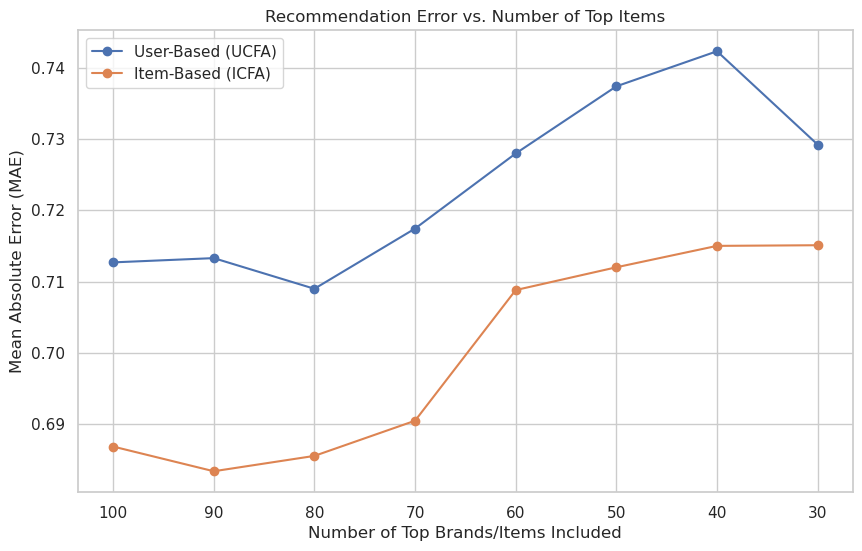

In [ ]:
import matplotlib.pyplot as plt

# 1. Get the list of the top 100 most popular items
item_counts_filtered = df_filtered['parent_asin'].value_counts()
top_100_items = item_counts_filtered.head(100).index.tolist()

# 2. Prepare to store the results
results_mae = []

# 3. Loop from top 100 down to top 30 items
for n in range(100, 29, -10):

    # Create subset of data with only the top N items
    top_n_items = top_100_items[:n]
    df_subset = df_filtered[df_filtered['parent_asin'].isin(top_n_items)]

    print(f"\nEvaluating with Top {n} items... (Dataset size: {len(df_subset)})")

    # Load the subset into Surprise
    data_subset = Dataset.load_from_df(df_subset[['user_id', 'parent_asin', 'rating']], reader)

    # Run cross-validation for both models on the subset
    cv_ucfa = cross_validate(ucfa, data_subset, measures=['MAE'], cv=3, verbose=False)
    cv_icfa = cross_validate(icfa, data_subset, measures=['MAE'], cv=3, verbose=False)

    # Store the average MAE
    mae_user = cv_ucfa['test_mae'].mean()
    mae_item = cv_icfa['test_mae'].mean()
    results_mae.append({'N': n, 'user_based_mae': mae_user, 'item_based_mae': mae_item})

    print(f"  User-Based MAE: {mae_user:.4f}")
    print(f"  Item-Based MAE: {mae_item:.4f}")

# 4. Convert results to a DataFrame for easy plotting
results_df = pd.DataFrame(results_mae).set_index('N')

# 5. Plot the results to replicate the paper's findings
plt.figure(figsize=(10, 6))
plt.plot(results_df.index, results_df['user_based_mae'], marker='o', label='User-Based (UCFA)')
plt.plot(results_df.index, results_df['item_based_mae'], marker='o', label='Item-Based (ICFA)')

plt.title('Recommendation Error vs. Number of Top Items')
plt.xlabel('Number of Top Brands/Items Included')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend()
plt.gca().invert_xaxis() # Invert x-axis to match the paper's style
plt.grid(True)
plt.show()

### Item-Based (ICFA) is the Clear Winner

> Item-Based (ICFA) model has a consistently lower MAE (error) than the User-Based (UCFA) model.
>
- Baseline Error: 0.7189 (ICFA) vs. 0.7578 (UCFA)
- This confirms a key part of the paper: ICFA is the better, more accurate algorithm for this type of sparse e-commerce data.

### The "Goldilocks" Effect
- Baseline (Too Sparse): From "core" dataset of 122,627 reviews is still extremely sparse (we can calculate it as 1 - (122,627 / (34,480 users * 6,672 items)) = 99.95% sparse). The baseline error of 0.7189 is high because the model is struggling with so much noise and so many "empty" ratings.
- The Sweet Spot (Top 80-100): Filtering down to the Top 100 items (23k reviews) and Top 90 items (22k reviews), the error improves significantly down to ~0.683. By focusing on this popular group, the dataset becomes denser, and the model can make better predictions.
- Information Loss (Too Small): Filtering even more (from N=80 down to N=40), the error starts to climb back up (from 0.685 to 0.715). This is the "information loss". The dataset is now too small and lost the item diversity that helps the model learn.

> Filtering does improve performance by reducing sparsity. There is a "Goldilocks" zone (around the Top 90 items) that provides the best balance between data density and item diversity.


## 1. Data Selection and Exploratory Data Analysis (EDA)

The foundation of this project is the **McAuley-Lab Amazon-Reviews-2023 dataset**, loaded via the HuggingFace `datasets` library. We selected the `0core_rating_only_Appliances` subset, which provided 2,103,990 ratings.

An initial exploratory analysis confirmed the dataset's extreme sparsity, a central challenge identified in the research paper. The data comprised:
* **Unique Users:** 1,755,732
* **Unique Items:** 94,319
* **Interactions:** 2,103,990

The user and item distributions exhibited a "long-tail" effect, with a small number of users and items accounting for a large portion of the reviews, while the vast majority had only one or two entries. The calculated sparsity of the user-item matrix was **99.998%**, making analysis on the raw dataset computationally infeasible and highly susceptible to noise.

---

## 2. Data Preprocessing

To create a viable "core" dataset for analysis, an iterative filtering process was applied, as recommended in the course material. We set a `min_user_reviews` threshold of 3 and a `min_item_reviews` threshold of 5.

This preprocessing phase iteratively removed users and items below these thresholds until the dataset stabilized. The final filtered dataset was significantly more manageable:

* **Original Shape:** (2,103,990, 4)
* **Filtered Shape:** (122,627, 4)

This "core" dataset consisted of **122,627 interactions** from **34,480 unique users** and **6,672 unique items**. While still highly sparse (99.95%), this denser subset provided a robust foundation for modeling.

---

## 3. Data Mining Methods and Analysis

### Model 1: Association Rule Mining (Apriori)

First, we replicated the market basket analysis to find co-purchase patterns. User review lists were converted into transactions. The Apriori algorithm was applied with a low `min_support` of 0.001 (to find relationships in the sparse data) and a `min_confidence` of 0.2.

The analysis successfully generated **40 strong association rules** from 746 frequent itemsets.

* **Key Insight 1 (High Lift):** The results showed many rules with exceptionally high **lift** values (e.g., 64.2, 83.3, 219.1). A high lift indicates that the items are purchased together far more often than by random chance, confirming the algorithm's ability to find strong complementary products (like accessories and their main devices).
* **Key Insight 2 (3-Item Rules):** The model also identified multi-item rules, such as `(B07P3Y8JWY, B07RNJY499) -> (B09CBF2XCF)`. This is a powerful insight, as all three of these items are among the top 10 most popular products. This shows that even among best-sellers, strong, non-obvious co-purchase patterns exist. People who buy reusable Keurig pods (Antecedents: B07P3Y8JWY, B07RNJY499) are also very likely to buy the accessory used to fill those pods (Consequent: B09CBF2XCF).

![image.png](attachment:08bba428-21a9-4560-af81-2709c71e2cc8.png)

Figure 1: Results of the Association Rule Mining Analysis [from [link](https://www.amazon.com/stores/Keurig/page/60C51055-C8F7-4898-9C8E-119B62841040))

### Model 2: Collaborative Filtering (CF)

This was the primary analysis, designed to test the paper's central hypothesis regarding data sparsity. We implemented both User-Based (UCFA) and Item-Based (ICFA) collaborative filtering using the `Surprise` library, with Mean Absolute Error (MAE) as the evaluation metric.

#### Finding 1: Baseline Performance (ICFA vs. UCFA)
First, a baseline was established on the entire 122,627-interaction "core" dataset. The results immediately confirmed a key finding from the original paper:

* **Baseline User-Based MAE:** 0.7578
* **Baseline Item-Based MAE:** 0.7189

**Item-Based CF (ICFA) was demonstrably more accurate** than User-Based CF (UCFA). This superiority was consistent across all subsequent experiments, reinforcing its suitability for this type of data.

#### Finding 2: The "Top N" Popularity Experiment
Next, we tested the paper's main hypothesis. We ran the CF models on progressively smaller subsets of the data, including only the "Top N" most popular items (from N=100 down to N=30).

![image.png](attachment:c5577872-8773-4cd7-8df0-661fce7eefad.png)

Figure 2: Results of the "Top N" Popularity Experiment

The results, visualized in the plot, reveal a nuanced and critical "Goldilocks" effect:

* **Initial Improvement:** When filtering from the full "core" dataset (baseline ICFA MAE: 0.7189) to the **Top 100 items**, the MAE *improved* to **0.6869**. It reached its optimal point at the **Top 90 items**, with an MAE of **0.6834**. This confirms the paper's hypothesis: filtering by popularity *can* improve accuracy by reducing noise and creating a denser dataset for the model to learn from.

* **Subsequent Degradation:** However, as the filtering became more aggressive (from N=80 down to N=30), the MAE began to steadily *increase* again, rising from 0.6856 back up to 0.7151.

---

## 4. Conclusion and Reflection

This project successfully replicated and extended the findings of the assigned paper.

1.  We confirmed that **Item-Based Collaborative Filtering** is more accurate than User-Based CF for this sparse e-commerce data.
2.  We demonstrated that **Association Rule Mining** can effectively uncover non-obvious, high-lift relationships between products, even among best-sellers.
3.  Most importantly, we refined the paper's conclusion on sparsity. Filtering by popularity is not a simple "more is better" solution. There is a clear **"sweet spot" (around the Top 90 items in our case)** where the dataset is dense enough to improve predictions. Beyond this point, **information loss** occurs; the model loses the item diversity and nuanced preference data it needs, causing performance to degrade. This highlights a critical trade-off between data density and data diversity in building effective recommender systems.

![Durring Execution](<attachment:Screenshot from 2025-10-23 10-48-57_x.png>)

During execution.

![OS Specifications](attachment:image.png)